# Exercises - Estimating the Spot Curve
## Solutions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')

xlsx_file = "/Users/lin_/Desktop/37400 FixedIncome/data/treasury_quotes_2025-11-28.xlsx"
selected_quotes = pd.read_excel(xlsx_file, sheet_name='selected quotes')
quotes = pd.read_excel(xlsx_file, sheet_name='quotes')

QUOTE_DATE = pd.Timestamp('2025-11-28')
print(f"Quote Date: {QUOTE_DATE.date()}")
print(f"Selected quotes shape: {selected_quotes.shape}")
print(f"All quotes shape: {quotes.shape}")

Quote Date: 2025-11-28
Selected quotes shape: (20, 16)
All quotes shape: (455, 16)


---
# 1. Discount Rates

Using the data in the `selected quotes` tab.

In [3]:
print("Selected Quotes Data:")
display(selected_quotes[['type', 'maturity date', 'ttm', 'cpn rate', 'price', 'dirty price', 'ytm']])

Selected Quotes Data:


,type,maturity date,ttm,cpn rate,price,dirty price,ytm
0,note,2026-05-31,0.503765,4.875,100.526313,102.937174,0.038263
1,note,2026-11-30,1.004791,4.250,100.582015,102.683791,0.036575
2,note,2027-05-31,1.503080,3.875,100.462891,102.379216,0.035621
3,note,2027-11-30,2.004107,3.375,99.767578,99.767578,0.034889
4,note,2028-05-31,2.505133,3.625,100.322266,102.114957,0.034901
5,note,2028-11-30,3.006160,4.375,102.455078,104.618671,0.035065
6,note,2029-05-31,3.504449,4.500,103.189453,105.414863,0.035258
7,note,2029-11-30,4.005476,4.125,102.105469,104.145428,0.035564
8,note,2030-05-31,4.503765,4.000,101.757812,103.735955,0.035754
9,note,2030-11-30,5.004791,3.500,99.550781,99.550781,0.035953


### 1.1. Create the Cashflow Matrix C

Each row is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of $100.

**Note:** The selected treasuries mature at nearly 6-month intervals. We approximate with perfect 6-month intervals as suggested.

In [4]:
def build_cashflow_matrix_6mo(df, quote_date):
    """Build cashflow matrix assuming perfect 6-month intervals."""
    df = df.copy().sort_values('ttm').reset_index(drop=True)
    n_bonds = len(df)
    
    cpn_rates = df['cpn rate'].values
    prices = df['dirty price'].values
    ttm_actual = df['ttm'].values
    
    # Create perfect 6-month intervals from 0.5 to ceil(max_ttm/0.5)*0.5
    max_periods = int(np.ceil(max(ttm_actual) / 0.5))
    ttm_dates = np.arange(1, max_periods + 1) * 0.5
    n_dates = len(ttm_dates)
    
    # Each bond matures at the nearest 6-month interval
    mat_periods = np.round(ttm_actual / 0.5).astype(int)
    
    C = np.zeros((n_bonds, n_dates))
    
    for i in range(n_bonds):
        cpn = cpn_rates[i] / 2  # Semiannual coupon
        mat_period = mat_periods[i]
        
        for j in range(mat_period):
            if j + 1 == mat_period:  # Maturity
                C[i, j] = 100 + cpn
            else:
                C[i, j] = cpn
    
    return C, ttm_dates, prices, df

C, ttm_dates, prices, df_sorted = build_cashflow_matrix_6mo(selected_quotes, QUOTE_DATE)

print(f"Cashflow Matrix Shape: {C.shape}")
print(f"Number of bonds: {C.shape[0]}")
print(f"Number of payment dates (6-month periods): {C.shape[1]}")
print(f"\nPayment dates (years from now): {ttm_dates}")

C_df = pd.DataFrame(C, 
                    index=[f"Bond {i+1} (mat ~{t:.1f}y)" for i, t in enumerate(df_sorted['ttm'])],
                    columns=[f"t={t:.1f}" for t in ttm_dates])
print("\nCashflow Matrix C:")
display(C_df.round(2))

Cashflow Matrix Shape: (20, 20)
Number of bonds: 20
Number of payment dates (6-month periods): 20

Payment dates (years from now): [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]

Cashflow Matrix C:


,t=0.5,t=1.0,t=1.5,t=2.0,t=2.5,t=3.0,t=3.5,t=4.0,t=4.5,t=5.0,t=5.5,t=6.0,t=6.5,t=7.0,t=7.5,t=8.0,t=8.5,t=9.0,t=9.5,t=10.0
Bond 1 (mat ~0.5y),102.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 2 (mat ~1.0y),2.12,102.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 3 (mat ~1.5y),1.94,1.94,101.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 4 (mat ~2.0y),1.69,1.69,1.69,101.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 5 (mat ~2.5y),1.81,1.81,1.81,1.81,101.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 6 (mat ~3.0y),2.19,2.19,2.19,2.19,2.19,102.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 7 (mat ~3.5y),2.25,2.25,2.25,2.25,2.25,2.25,102.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 8 (mat ~4.0y),2.06,2.06,2.06,2.06,2.06,2.06,2.06,102.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 9 (mat ~4.5y),2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,102.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
Bond 10 (mat ~5.0y),1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,101.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


### 1.2. Estimate Spot Discount Factors

Solve the linear system: $\mathbf{p} = \mathbf{C} \mathbf{z}$

Since we have 20 bonds and 20 payment dates, this is a square system that can be solved exactly.

In [5]:
p = prices.copy()

print(f"Number of bonds: {len(p)}")
print(f"Number of dates: {C.shape[1]}")

# For a square system, we can solve exactly
# But let's use lstsq which handles both square and non-square cases
z_ols, residuals, rank, s = np.linalg.lstsq(C, p, rcond=None)

print(f"\nDiscount Factors (z):")
for t, z in zip(ttm_dates, z_ols):
    print(f"  t = {t:4.1f} years: z = {z:.6f}")

p_modeled = C @ z_ols
pricing_errors = p - p_modeled

print(f"\nPricing Errors:")
print(f"  Max absolute error: ${np.max(np.abs(pricing_errors)):.6f}")
print(f"  RMSE: ${np.sqrt(np.mean(pricing_errors**2)):.6f}")

Number of bonds: 20
Number of dates: 20

Discount Factors (z):
  t =  0.5 years: z = 1.004878
  t =  1.0 years: z = 0.984562
  t =  1.5 years: z = 0.966520
  t =  2.0 years: z = 0.932065
  t =  2.5 years: z = 0.933755
  t =  3.0 years: z = 0.920573
  t =  3.5 years: z = 0.904592
  t =  4.0 years: z = 0.886086
  t =  4.5 years: z = 0.869313
  t =  5.0 years: z = 0.833874
  t =  5.5 years: z = 0.837648
  t =  6.0 years: z = 0.818479
  t =  6.5 years: z = 0.800906
  t =  7.0 years: z = 0.764311
  t =  7.5 years: z = 0.748785
  t =  8.0 years: z = 0.732351
  t =  8.5 years: z = 0.715579
  t =  9.0 years: z = 0.698483
  t =  9.5 years: z = 0.681960
  t = 10.0 years: z = 0.666245

Pricing Errors:
  Max absolute error: $0.000000
  RMSE: $0.000000


### 1.3. Plot Discount Factors and Discount Rates

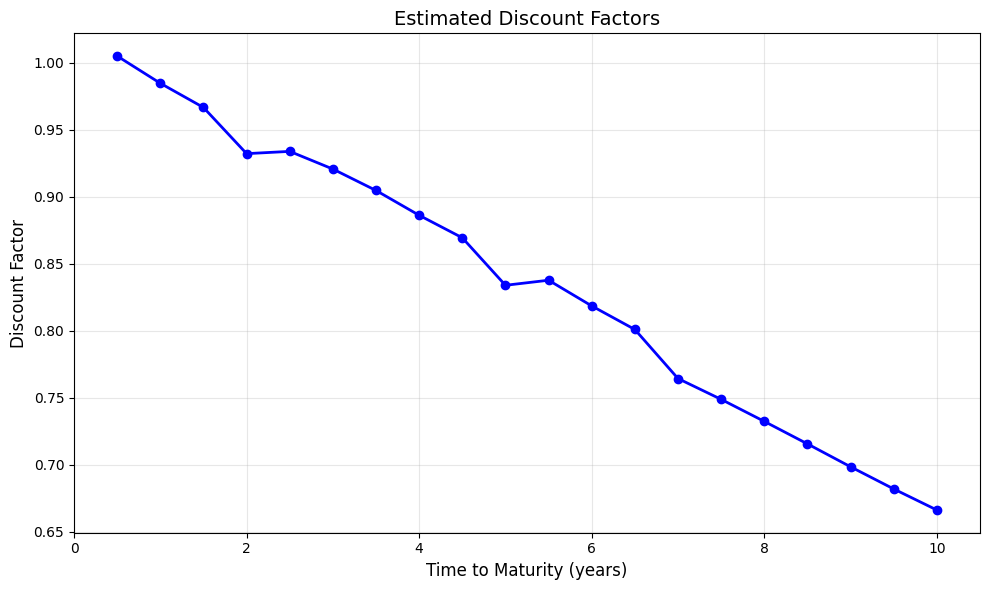

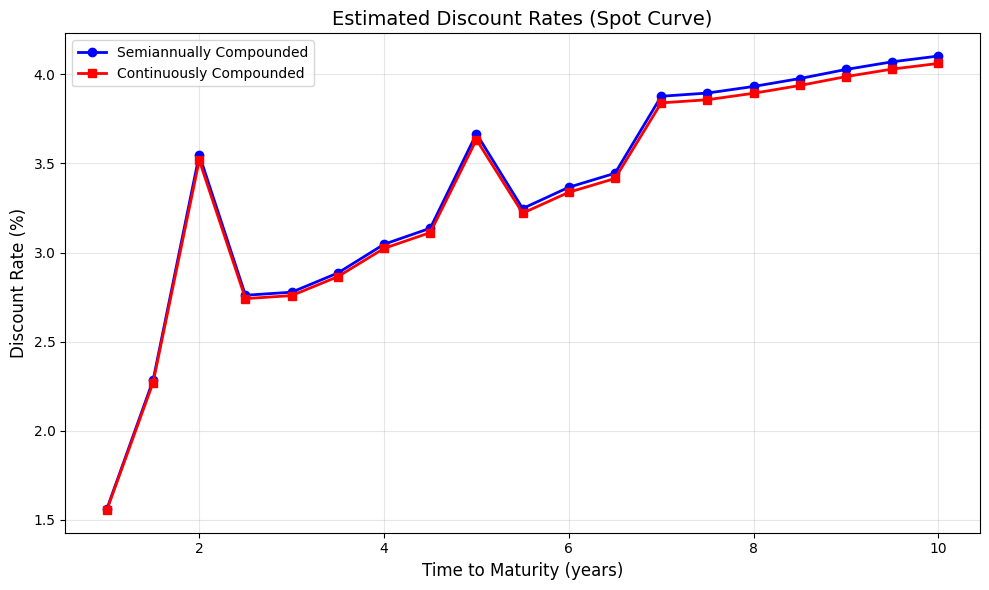


Discount Rates Summary:


,TTM (years),Discount Factor,Semi-Annual Rate (%),Continuous Rate (%)
0,0.5,1.0049,-0.9708,-0.9732
1,1.0,0.9846,1.5619,1.5558
2,1.5,0.9665,2.2831,2.2702
3,2.0,0.9321,3.5487,3.5176
4,2.5,0.9338,2.7605,2.7417
5,3.0,0.9206,2.7778,2.7586
6,3.5,0.9046,2.8855,2.8649
7,4.0,0.8861,3.0465,3.0235
8,4.5,0.8693,3.1366,3.1123
9,5.0,0.8339,3.6667,3.6335


In [6]:
def discount_to_semiannual_rate(z, t):
    """Convert discount factor to semiannually compounded rate."""
    if z <= 0 or t <= 0: return np.nan
    return 2 * (z ** (-1 / (2 * t)) - 1)

def discount_to_continuous_rate(z, t):
    """Convert discount factor to continuously compounded rate."""
    if z <= 0 or t <= 0: return np.nan
    return -np.log(z) / t

semi_rates = np.array([discount_to_semiannual_rate(z, t) for z, t in zip(z_ols, ttm_dates)])
cont_rates = np.array([discount_to_continuous_rate(z, t) for z, t in zip(z_ols, ttm_dates)])

# Plot 1: Discount Factors
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ttm_dates, z_ols, 'b-o', linewidth=2, markersize=6)
ax.set_xlabel('Time to Maturity (years)', fontsize=12)
ax.set_ylabel('Discount Factor', fontsize=12)
ax.set_title('Estimated Discount Factors', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, max(ttm_dates) + 0.5)
plt.tight_layout()
plt.show()

# Plot 2: Discount Rates
fig, ax = plt.subplots(figsize=(10, 6))
mask = (semi_rates > 0) & (semi_rates < 0.2)  # Filter valid rates
ax.plot(ttm_dates[mask], semi_rates[mask] * 100, 'b-o', linewidth=2, markersize=6, label='Semiannually Compounded')
ax.plot(ttm_dates[mask], cont_rates[mask] * 100, 'r-s', linewidth=2, markersize=6, label='Continuously Compounded')
ax.set_xlabel('Time to Maturity (years)', fontsize=12)
ax.set_ylabel('Discount Rate (%)', fontsize=12)
ax.set_title('Estimated Discount Rates (Spot Curve)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDiscount Rates Summary:")
rate_df = pd.DataFrame({
    'TTM (years)': ttm_dates,
    'Discount Factor': z_ols,
    'Semi-Annual Rate (%)': semi_rates * 100,
    'Continuous Rate (%)': cont_rates * 100
})
display(rate_df.round(4))

### 1.4. Nelson-Siegel Curve Fitting

The Nelson-Siegel model for the spot rate is:

$$r(t) = \beta_0 + \beta_1 \left( \frac{1 - e^{-t/\lambda}}{t/\lambda} \right) + \beta_2 \left( \frac{1 - e^{-t/\lambda}}{t/\lambda} - e^{-t/\lambda} \right)$$

We fit by minimizing the sum of squared pricing errors.

In [7]:
def nelson_siegel_rate(t, beta0, beta1, beta2, lam):
    """Nelson-Siegel spot rate (continuously compounded)."""
    t = np.maximum(np.asarray(t), 1e-10)
    tau = t / lam
    factor1 = (1 - np.exp(-tau)) / tau
    factor2 = factor1 - np.exp(-tau)
    return beta0 + beta1 * factor1 + beta2 * factor2

def nelson_siegel_discount(t, beta0, beta1, beta2, lam):
    """Discount factor from Nelson-Siegel model."""
    r = nelson_siegel_rate(t, beta0, beta1, beta2, lam)
    return np.exp(-r * t)

def ns_objective(params, C, p, ttm_dates):
    """Sum of squared pricing errors."""
    beta0, beta1, beta2, lam = params
    if lam <= 0.01: return 1e10
    z_ns = nelson_siegel_discount(ttm_dates, beta0, beta1, beta2, lam)
    if np.any(z_ns <= 0) or np.any(z_ns > 1.5) or np.any(np.isnan(z_ns)): return 1e10
    p_modeled = C @ z_ns
    return np.sum((p - p_modeled) ** 2)

# Global optimization
bounds = [(0.02, 0.08), (-0.03, 0.03), (-0.08, 0.08), (0.5, 4.0)]

result = differential_evolution(ns_objective, bounds, args=(C, p, ttm_dates),
                                 seed=42, maxiter=2000, tol=1e-10, polish=True)

beta0_opt, beta1_opt, beta2_opt, lam_opt = result.x

print("Nelson-Siegel Estimated Parameters:")
print(f"  β₀ (level):     {beta0_opt:.6f} ({beta0_opt*100:.2f}%)")
print(f"  β₁ (slope):     {beta1_opt:.6f}")
print(f"  β₂ (curvature): {beta2_opt:.6f}")
print(f"  λ (decay):      {lam_opt:.6f}")
print(f"\nOptimization converged: {result.success}")

z_ns = nelson_siegel_discount(ttm_dates, beta0_opt, beta1_opt, beta2_opt, lam_opt)
p_ns = C @ z_ns
print(f"\nPricing Errors (NS model):")
print(f"  Max absolute error: ${np.max(np.abs(p - p_ns)):.4f}")
print(f"  RMSE: ${np.sqrt(np.mean((p - p_ns)**2)):.4f}")

Nelson-Siegel Estimated Parameters:
  β₀ (level):     0.052097 (5.21%)
  β₁ (slope):     -0.030000
  β₂ (curvature): -0.029676
  λ (decay):      1.928918

Optimization converged: True

Pricing Errors (NS model):
  Max absolute error: $1.8140
  RMSE: $0.7890


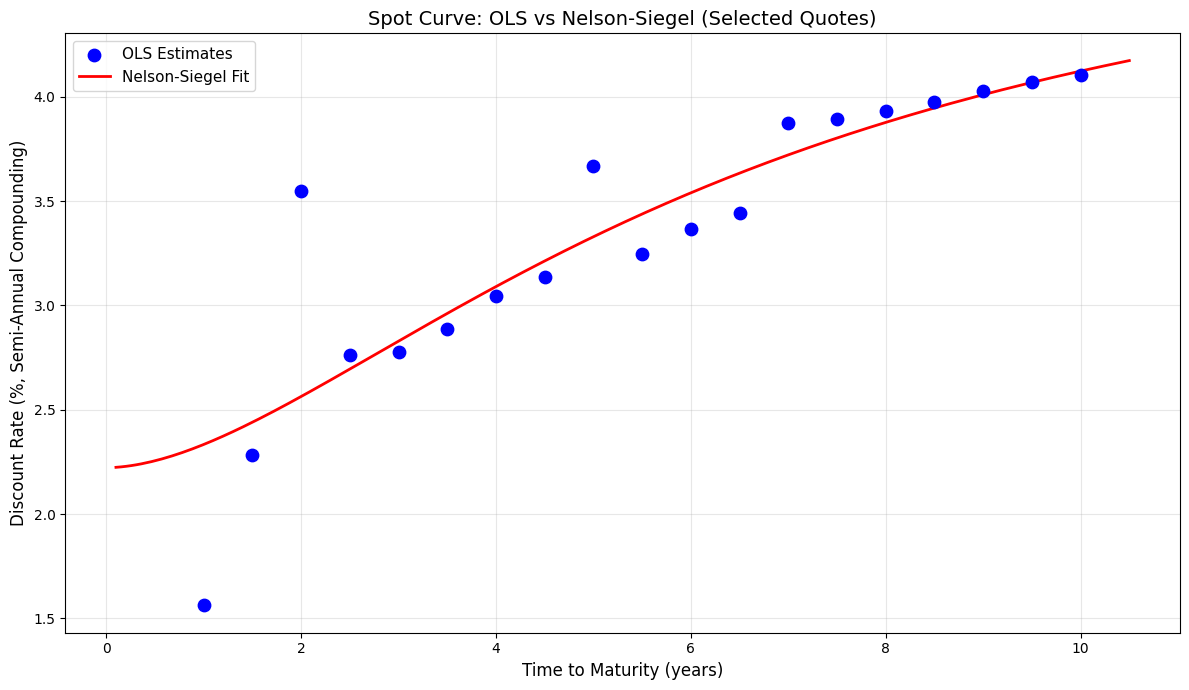

In [8]:
# Plot: OLS vs Nelson-Siegel
fig, ax = plt.subplots(figsize=(12, 7))

t_smooth = np.linspace(0.1, max(ttm_dates) + 0.5, 200)
r_ns_smooth = nelson_siegel_rate(t_smooth, beta0_opt, beta1_opt, beta2_opt, lam_opt)
r_ns_semi = 2 * (np.exp(r_ns_smooth / 2) - 1)

mask = (semi_rates > 0) & (semi_rates < 0.2)
ax.scatter(ttm_dates[mask], semi_rates[mask] * 100, s=80, c='blue', marker='o', label='OLS Estimates', zorder=3)
ax.plot(t_smooth, r_ns_semi * 100, 'r-', linewidth=2, label='Nelson-Siegel Fit')

ax.set_xlabel('Time to Maturity (years)', fontsize=12)
ax.set_ylabel('Discount Rate (%, Semi-Annual Compounding)', fontsize=12)
ax.set_title('Spot Curve: OLS vs Nelson-Siegel (Selected Quotes)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# 2. Estimating the Discount Curve with Non-Evenly Spaced Data

Using the data in the `quotes` tab.

In [9]:
quotes_nominal = quotes[~quotes['type'].isin(['TIPS Note', 'TIPS bond'])].copy()
print(f"Total quotes: {len(quotes)}")
print(f"Nominal quotes (excluding TIPS): {len(quotes_nominal)}")
print(f"\nSecurity types:")
print(quotes_nominal['type'].value_counts())

Total quotes: 455
Nominal quotes (excluding TIPS): 431

Security types:
type
note         242
bond         108
bill          52
TIPS note     29
Name: count, dtype: int64


### 2.1. Construct the Cashflow Matrix

- Eliminate treasuries without YTM or with negative YTM
- Notes and bonds pay coupons every 6 months going backward from maturity

In [10]:
quotes_filtered = quotes_nominal[(quotes_nominal['ytm'].notna()) & (quotes_nominal['ytm'] > 0)].copy()
print(f"Quotes after filtering for valid YTM: {len(quotes_filtered)}")
print(f"\nSecurity types:")
print(quotes_filtered['type'].value_counts())

Quotes after filtering for valid YTM: 402

Security types:
type
note    242
bond    108
bill     52
Name: count, dtype: int64


In [11]:
def build_cashflow_matrix_full(df, quote_date):
    """Build cashflow matrix for all nominal treasuries."""
    df = df.copy().reset_index(drop=True)
    n_bonds = len(df)
    
    all_dates = set()
    bond_cashflows = []
    
    for idx, row in df.iterrows():
        mat_date = pd.to_datetime(row['maturity date'])
        bond_type = row['type']
        cpn_rate = row['cpn rate']
        cashflows = {}
        
        if bond_type == 'bill':
            cashflows[mat_date] = 100
            all_dates.add(mat_date)
        else:
            cpn = cpn_rate / 2
            cpn_date = mat_date
            while cpn_date > quote_date:
                all_dates.add(cpn_date)
                cashflows[cpn_date] = 100 + cpn if cpn_date == mat_date else cpn
                cpn_date = cpn_date - pd.DateOffset(months=6)
        bond_cashflows.append(cashflows)
    
    all_dates = sorted(all_dates)
    n_dates = len(all_dates)
    date_to_idx = {d: i for i, d in enumerate(all_dates)}
    
    C = np.zeros((n_bonds, n_dates))
    for i, cashflows in enumerate(bond_cashflows):
        for date, cf in cashflows.items():
            C[i, date_to_idx[date]] = cf
    
    ttm_dates = np.array([(d - quote_date).days / 365.0 for d in all_dates])
    return C, ttm_dates, df['dirty price'].values, all_dates, df

C_full, ttm_full, prices_full, dates_full, df_filtered = build_cashflow_matrix_full(quotes_filtered, QUOTE_DATE)

print(f"Cashflow Matrix Shape: {C_full.shape}")
print(f"Number of bonds: {C_full.shape[0]}")
print(f"Number of unique payment dates: {C_full.shape[1]}")

Cashflow Matrix Shape: (402, 312)
Number of bonds: 402
Number of unique payment dates: 312


In [12]:
C_full_df = pd.DataFrame(C_full, index=df_filtered['KYTREASNO'].values,
                          columns=[d.strftime('%Y-%m-%d') for d in dates_full])

print("Cashflow Matrix C - Head:")
display(C_full_df.iloc[:5, :8])

print("\nCashflow Matrix C - Tail:")
display(C_full_df.iloc[-5:, -8:])

Cashflow Matrix C - Head:


,2025-11-30,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18
208422,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0



Cashflow Matrix C - Tail:


,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
208322,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.000,0.0000
208362,2.3125,0.0000,2.3125,0.0000,102.3125,0.0000,0.000,0.0000
208405,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000
208448,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.375,0.0000
208490,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125


In [13]:
# Date with most cashflow
total_cf = C_full.sum(axis=0)
max_cf_idx = np.argmax(total_cf)
print(f"Date with most total cashflow: {dates_full[max_cf_idx].strftime('%Y-%m-%d')}")
print(f"Total cashflow: ${total_cf[max_cf_idx]:,.2f}")

# Date with most issues
n_issues = np.sum(C_full > 0, axis=0)
max_issues_idx = np.argmax(n_issues)
print(f"\nDate with most issues paying: {dates_full[max_issues_idx].strftime('%Y-%m-%d')}")
print(f"Number of issues: {n_issues[max_issues_idx]}")

Date with most total cashflow: 2026-04-30
Total cashflow: $444.50

Date with most issues paying: 2026-02-15
Number of issues: 82


### 2.2. OLS Estimation

Create subset Ĉ where every date column has at least one maturity.

In [14]:
def create_filtered_matrix(C, ttm_dates, prices, dates, df):
    """Filter to dates that are maturities."""
    maturity_mask = np.any(C >= 100, axis=0)
    maturity_idx = np.where(maturity_mask)[0]
    
    bond_maturities = np.array([np.where(C[i,:] >= 100)[0][0] if np.any(C[i,:] >= 100) else -1 
                                 for i in range(C.shape[0])])
    
    valid_bonds = [i for i in range(len(bond_maturities)) 
                   if bond_maturities[i] >= 0 and bond_maturities[i] in maturity_idx]
    
    C_hat = C[np.ix_(valid_bonds, maturity_idx)]
    ttm_hat = ttm_dates[maturity_idx]
    prices_hat = prices[valid_bonds]
    dates_hat = [dates[i] for i in maturity_idx]
    df_hat = df.iloc[valid_bonds].copy()
    
    return C_hat, ttm_hat, prices_hat, dates_hat, df_hat

C_hat, ttm_hat, prices_hat, dates_hat, df_hat = create_filtered_matrix(
    C_full, ttm_full, prices_full, dates_full, df_filtered)

print(f"Filtered Matrix Ĉ Shape: {C_hat.shape}")
print(f"Number of bonds: {C_hat.shape[0]}")
print(f"Number of maturity dates: {C_hat.shape[1]}")

Filtered Matrix Ĉ Shape: (402, 270)
Number of bonds: 402
Number of maturity dates: 270


In [15]:
C_hat_df = pd.DataFrame(C_hat, index=df_hat['KYTREASNO'].values,
                         columns=[d.strftime('%Y-%m-%d') for d in dates_hat])
print("Filtered Ĉ - Head (5 rows):")
display(C_hat_df.iloc[:5, :6])
print("\nFiltered Ĉ - Tail (5 rows):")
display(C_hat_df.iloc[-5:, -6:])

Filtered Ĉ - Head (5 rows):


,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16
208422,100.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,100.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,100.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,100.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,102.0,0.0



Filtered Ĉ - Tail (5 rows):


,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
208322,0.0000,102.2500,0.0000,0.0000,0.000,0.0000
208362,2.3125,0.0000,102.3125,0.0000,0.000,0.0000
208405,0.0000,2.3750,0.0000,102.3750,0.000,0.0000
208448,2.3750,0.0000,2.3750,0.0000,102.375,0.0000
208490,0.0000,2.3125,0.0000,2.3125,0.000,102.3125


In [16]:
z_ols_full, _, _, _ = np.linalg.lstsq(C_hat, prices_hat, rcond=None)

p_mod = C_hat @ z_ols_full
errors = prices_hat - p_mod

print(f"OLS Discount Factors: {len(z_ols_full)}")
print(f"\nPricing Errors:")
print(f"  Max: ${np.max(np.abs(errors)):.4f}")
print(f"  RMSE: ${np.sqrt(np.mean(errors**2)):.4f}")

OLS Discount Factors: 270

Pricing Errors:
  Max: $2.7045
  RMSE: $0.6277


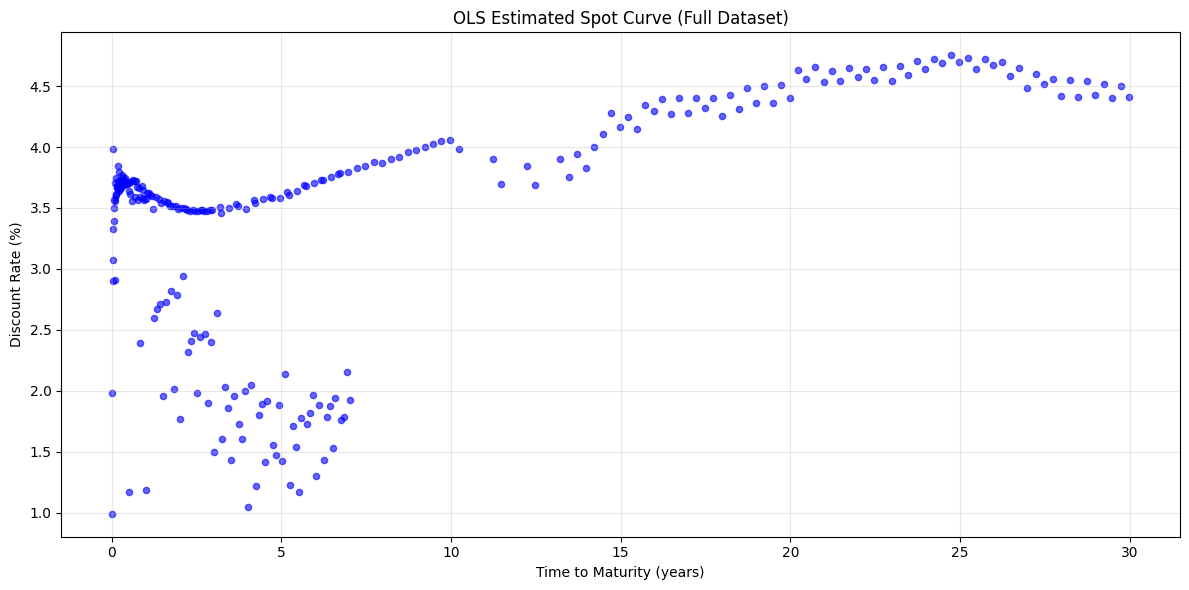

In [17]:
semi_rates_ols = np.array([discount_to_semiannual_rate(z, t) if z > 0 else np.nan 
                            for z, t in zip(z_ols_full, ttm_hat)])

fig, ax = plt.subplots(figsize=(12, 6))
mask = (semi_rates_ols > 0) & (semi_rates_ols < 0.1)
ax.scatter(ttm_hat[mask], semi_rates_ols[mask] * 100, s=20, alpha=0.6, c='blue')
ax.set_xlabel('Time to Maturity (years)')
ax.set_ylabel('Discount Rate (%)')
ax.set_title('OLS Estimated Spot Curve (Full Dataset)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2.3. Nelson-Siegel Curve Fitting

In [18]:
bounds_full = [(0.02, 0.08), (-0.03, 0.03), (-0.08, 0.08), (0.5, 4.0)]

result_full = differential_evolution(ns_objective, bounds_full, 
                                      args=(C_hat, prices_hat, ttm_hat),
                                      seed=42, maxiter=2000, polish=True)

beta0_f, beta1_f, beta2_f, lam_f = result_full.x

print("Nelson-Siegel Parameters (Full Dataset):")
print(f"  β₀: {beta0_f:.6f} ({beta0_f*100:.2f}%)")
print(f"  β₁: {beta1_f:.6f}")
print(f"  β₂: {beta2_f:.6f}")
print(f"  λ:  {lam_f:.6f}")

z_ns_f = nelson_siegel_discount(ttm_hat, beta0_f, beta1_f, beta2_f, lam_f)
p_ns_f = C_hat @ z_ns_f
print(f"\nNS Pricing RMSE: ${np.sqrt(np.mean((prices_hat - p_ns_f)**2)):.4f}")

Nelson-Siegel Parameters (Full Dataset):
  β₀: 0.054308 (5.43%)
  β₁: -0.012787
  β₂: -0.080000
  λ:  2.042583

NS Pricing RMSE: $2.5763


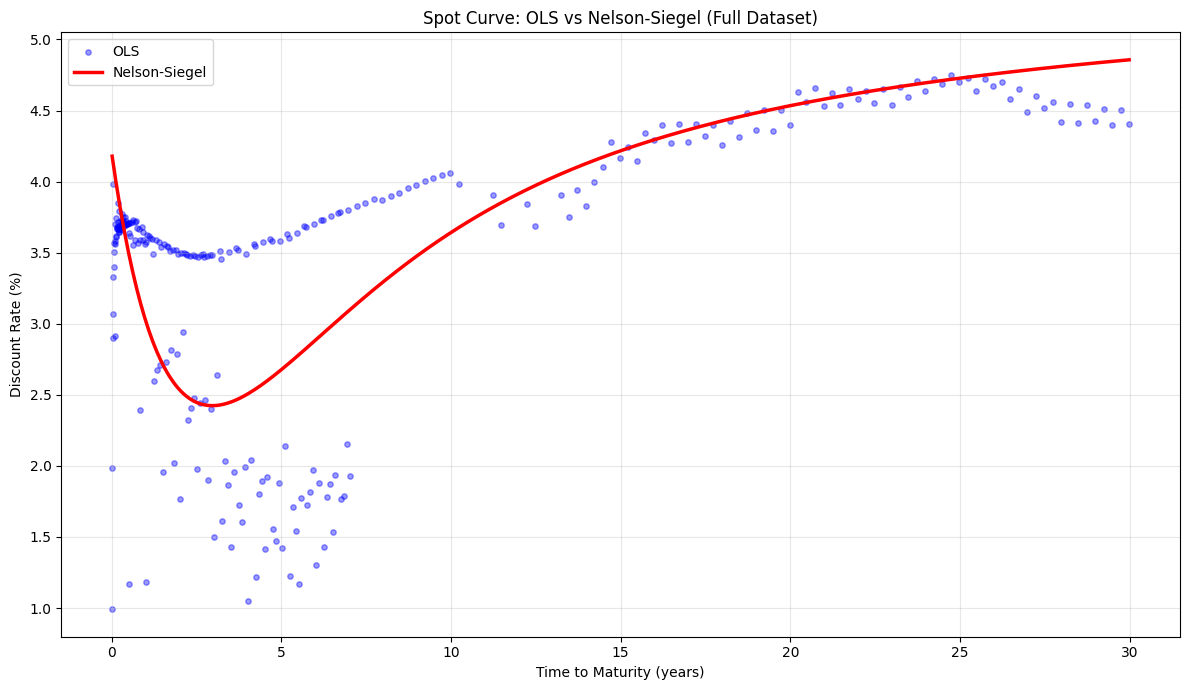

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))

t_sm = np.linspace(0.01, max(ttm_hat), 500)
r_ns_sm = nelson_siegel_rate(t_sm, beta0_f, beta1_f, beta2_f, lam_f)
r_ns_semi_sm = 2 * (np.exp(r_ns_sm / 2) - 1)

mask = (semi_rates_ols > 0) & (semi_rates_ols < 0.1)
ax.scatter(ttm_hat[mask], semi_rates_ols[mask] * 100, s=15, alpha=0.4, c='blue', label='OLS')
ax.plot(t_sm, r_ns_semi_sm * 100, 'r-', linewidth=2.5, label='Nelson-Siegel')

ax.set_xlabel('Time to Maturity (years)')
ax.set_ylabel('Discount Rate (%)')
ax.set_title('Spot Curve: OLS vs Nelson-Siegel (Full Dataset)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2.4. Weighted Least Squares

Weight more recently issued treasuries more heavily using exponential decay.

In [20]:
issue_dates = pd.to_datetime(df_hat['issue date'])
days_since = (QUOTE_DATE - issue_dates).dt.days

half_life = 365  # 1 year
weights = np.exp(-np.log(2) * days_since.values / half_life)
weights = weights / weights.sum() * len(weights)

print("Weight Statistics:")
print(f"  Min: {weights.min():.4f}, Max: {weights.max():.4f}")
print(f"  Mean: {weights.mean():.4f}, Std: {weights.std():.4f}")

Weight Statistics:
  Min: 0.0000, Max: 3.2507
  Mean: 1.0000, Std: 1.0614


In [21]:
W_sqrt = np.diag(np.sqrt(weights))
z_wls, _, _, _ = np.linalg.lstsq(W_sqrt @ C_hat, W_sqrt @ prices_hat, rcond=None)

p_wls = C_hat @ z_wls
errors_wls = prices_hat - p_wls

print(f"WLS Pricing Errors:")
print(f"  Max: ${np.max(np.abs(errors_wls)):.4f}")
print(f"  RMSE: ${np.sqrt(np.mean(errors_wls**2)):.4f}")

WLS Pricing Errors:
  Max: $13.9545
  RMSE: $1.2660


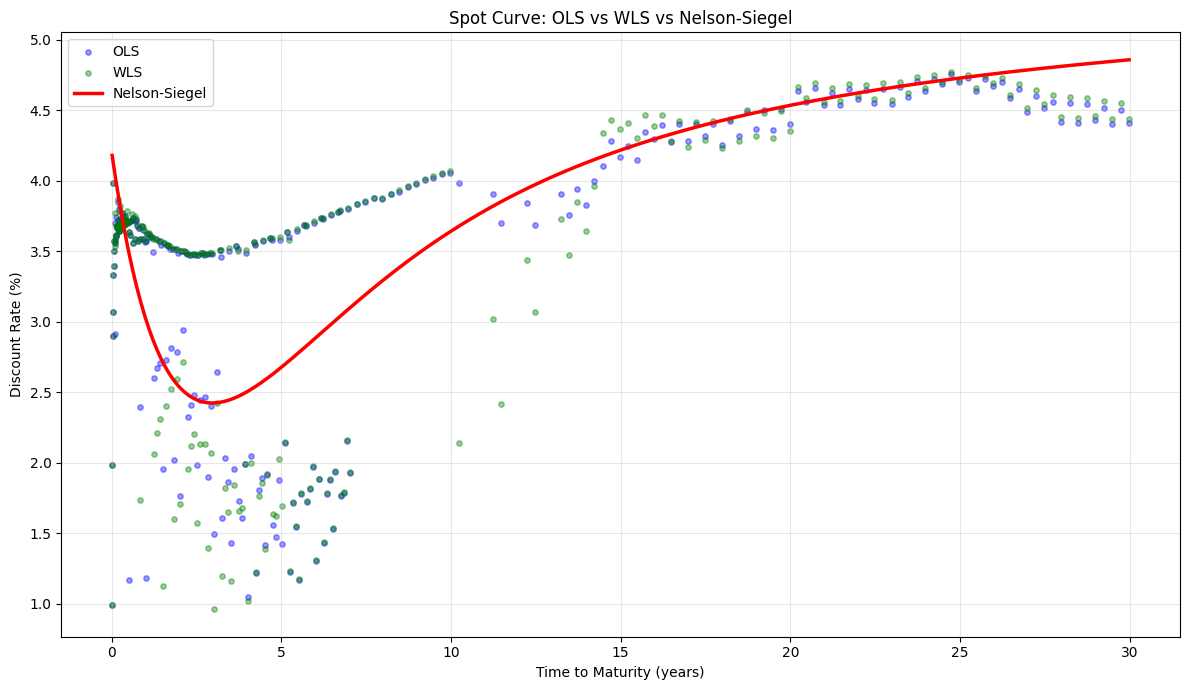

In [22]:
semi_rates_wls = np.array([discount_to_semiannual_rate(z, t) if z > 0 else np.nan 
                            for z, t in zip(z_wls, ttm_hat)])

fig, ax = plt.subplots(figsize=(12, 7))

mask_ols = (semi_rates_ols > 0) & (semi_rates_ols < 0.1)
mask_wls = (semi_rates_wls > 0) & (semi_rates_wls < 0.1)

ax.scatter(ttm_hat[mask_ols], semi_rates_ols[mask_ols] * 100, s=15, alpha=0.4, c='blue', label='OLS')
ax.scatter(ttm_hat[mask_wls], semi_rates_wls[mask_wls] * 100, s=15, alpha=0.4, c='green', label='WLS')
ax.plot(t_sm, r_ns_semi_sm * 100, 'r-', linewidth=2.5, label='Nelson-Siegel')

ax.set_xlabel('Time to Maturity (years)')
ax.set_ylabel('Discount Rate (%)')
ax.set_title('Spot Curve: OLS vs WLS vs Nelson-Siegel')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
mask_both = mask_ols & mask_wls
diff = (semi_rates_wls[mask_both] - semi_rates_ols[mask_both]) * 10000

print("OLS vs WLS Comparison:")
print(f"  Mean difference: {np.mean(diff):.2f} bps")
print(f"  Std difference: {np.std(diff):.2f} bps")
print(f"  Max |difference|: {np.max(np.abs(diff)):.2f} bps")

print("\n" + "="*50)
print("SUMMARY: Does WLS change the answer much?")
print("="*50)
if np.mean(np.abs(diff)) < 5:
    print("WLS results are very similar to OLS (< 5 bps average).")
elif np.mean(np.abs(diff)) < 20:
    print("WLS shows modest differences from OLS (5-20 bps average).")
else:
    print("WLS shows significant differences from OLS (> 20 bps average).")

print("\nWeighting recently issued bonds more heavily can help reduce")
print("the influence of off-the-run liquidity discounts.")

OLS vs WLS Comparison:
  Mean difference: -4.00 bps
  Std difference: 20.11 bps
  Max |difference|: 184.16 bps

SUMMARY: Does WLS change the answer much?
WLS shows modest differences from OLS (5-20 bps average).

Weighting recently issued bonds more heavily can help reduce
the influence of off-the-run liquidity discounts.


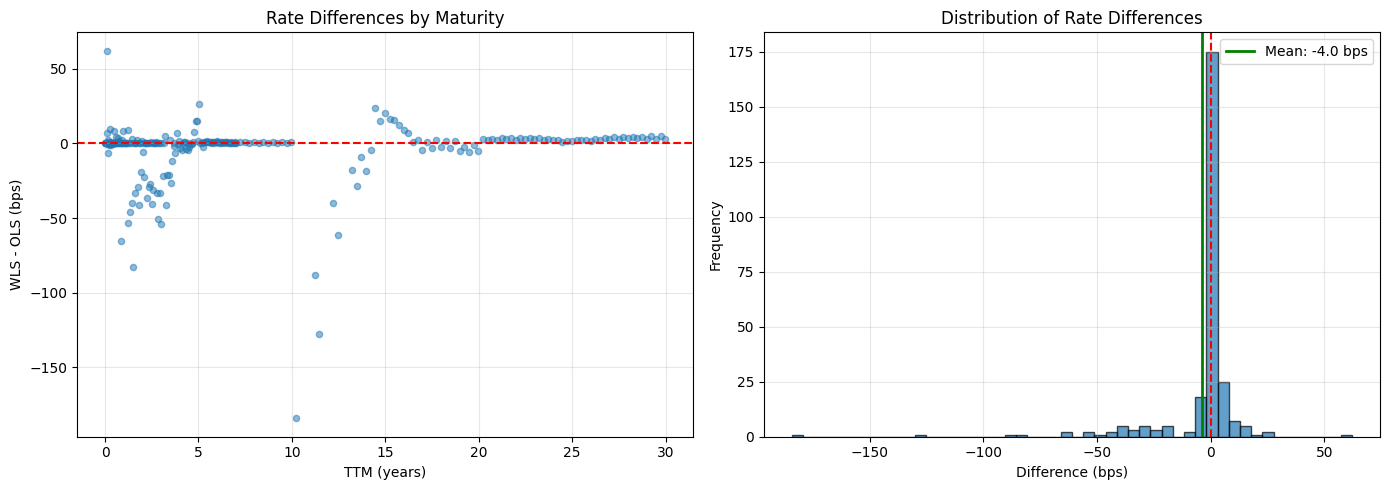

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(ttm_hat[mask_both], diff, s=20, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('TTM (years)')
axes[0].set_ylabel('WLS - OLS (bps)')
axes[0].set_title('Rate Differences by Maturity')
axes[0].grid(True, alpha=0.3)

axes[1].hist(diff, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].axvline(x=np.mean(diff), color='green', linewidth=2, label=f'Mean: {np.mean(diff):.1f} bps')
axes[1].set_xlabel('Difference (bps)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Rate Differences')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Summary

**Section 1:** Used 20 selected Treasury notes to estimate the spot curve via OLS and Nelson-Siegel.

**Section 2:** Extended the analysis to the full dataset (400+ securities), compared OLS, WLS, and Nelson-Siegel methods. WLS with exponential weighting on issue recency shows modest differences from OLS, helping account for on-the-run vs off-the-run liquidity effects.